# The Sparks Foundation

## Data Science and Business Analytics

### Stock Market Prediction using Numerical and Textual Analysis - By Sabyasachi Seal

<hr>

## Importing the libraries

In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
from sklearn import metrics 
import pandas as pd 
import numpy as np
import math

## Loading and Testing Stock Market Dataset

In [82]:
df_prices = pd.read_csv('Datasets/stockprices.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600


## Loading and Testing News Dataset

In [83]:
cols = ['Date', 'Category', 'News']
df_news = pd.read_csv("Datasets/news.csv", names=cols)
df_news = df_news.dropna(axis=0, how='any')
df_news

,Date,Category,News
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
149995,20021015,india,Post polls; India cringes as Pak finds acceptance
149996,20021015,india,Bangladesh is al-Qaeda's new haven: Time
149997,20021015,india,Hawk deal not finalised yet: India to UK
149998,20021015,city.kolkata,A helping hand to clear clinical waste


## Cleaning Data - Dropping Unwanted Values

In [84]:
df_news = df_news.drop_duplicates('Date', keep='first').sort_index()
df_news = df_news.reset_index()
df_news

,index,Date,Category,News
0,0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,86,20010103,unknown,Powerless north India gropes in the dark
2,127,20010104,unknown,The string that pulled Stephen Hawking to India
3,280,20010105,unknown,Light combat craft takes India into club class
4,406,20010106,unknown,Light combat craft takes India into club class
...,...,...,...,...
605,148794,20021011,business.india-business,Infy beats estimates; ups projection
606,149187,20021012,unknown,Tabreez set to conquer
607,149437,20021013,unknown,Note by note
608,149691,20021014,unknown,India lose to S Korea in men's hockey final


## Storing City Data

In [85]:
city_data = df_news[df_news['Category'].str.contains('^city\.[a-z]+$', regex=True)]
city_data

,index,Date,Category,News
8,642,20010110,city.patna,Fend for yourselves; Pande tells doctors
48,2215,20010309,city.delhi,Maneka asks govt to take back land for cow she...
114,4563,20010522,city.pune,She turned and fought
116,4693,20010527,city.bengaluru,Need to boost exports; says bank head
118,4917,20010529,city.bengaluru,US visit won't be piece of cake for Krishna
...,...,...,...,...
560,136831,20020827,city.hyderabad,Saki haunts night safari plan
573,140647,20020909,city.ahmedabad,Rs 1.33 lakh stolen from Ahmedabad post office
575,141210,20020911,city.mumbai,NGO opposes duty waiver on Sachin's Ferrari
586,143921,20020922,city.kolkata,SC asks state govt to explain custody deaths


## Extracting City Data

In [86]:
city_split = pd.DataFrame(columns=['City_Name'])
city_split['City_Name'] = city_data.Category.str.split('.',expand=True)[1]
city_data = pd.concat([city_data,city_split],axis=1)
city_data.drop(columns=['Category'],axis=1, inplace=True)
city_data.reset_index(inplace=True)
city_data.drop(['level_0','index'],axis=1, inplace=True)
city_data

,Date,News,City_Name
0,20010110,Fend for yourselves; Pande tells doctors,patna
1,20010309,Maneka asks govt to take back land for cow she...,delhi
2,20010522,She turned and fought,pune
3,20010527,Need to boost exports; says bank head,bengaluru
4,20010529,US visit won't be piece of cake for Krishna,bengaluru
...,...,...,...
163,20020827,Saki haunts night safari plan,hyderabad
164,20020909,Rs 1.33 lakh stolen from Ahmedabad post office,ahmedabad
165,20020911,NGO opposes duty waiver on Sachin's Ferrari,mumbai
166,20020922,SC asks state govt to explain custody deaths,kolkata


## Preprocessing - Coneverting the 'Date' columns to Datetime

In [87]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices.Date, format='%Y-%m-%d')
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600
...,...,...,...,...,...,...,...
1253,2022-02-18,49.080002,49.950001,48.669998,49.500000,49.500000,130500
1254,2022-02-22,49.080002,50.540001,48.970001,49.490002,49.490002,107200
1255,2022-02-23,50.099998,50.320000,49.049999,49.480000,49.480000,125300
1256,2022-02-24,48.349998,49.709999,47.070000,48.980000,48.980000,189600


## Plotting the Data 

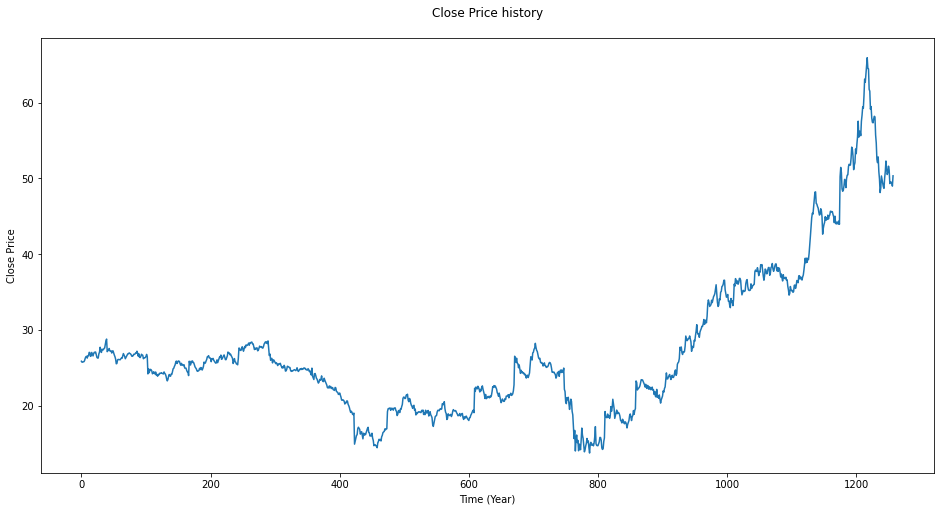

In [88]:
plt.figure(figsize=(16,8))
plt.title('Close Price history\n')
plt.xlabel('Time (Year)')
plt.ylabel('Close Price')
plt.plot(df_prices['Close'])

## Storing Closing Stock

In [89]:
def new_dataset(df_prices2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df_prices2)-look_back):
        a = df_prices2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df_prices2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

df2 = pd.read_csv('Datasets/stockprices.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

## Data Normalization

In [90]:
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

train_size = int(len(df2) * 0.80)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

look_back = 2
trainX, trainY = new_dataset(train, look_back)
testX, testY = new_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## LSTM Neural Network Model for Numerical Analysis

In [91]:
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=2)

Epoch 1/10
101/101 - 1s - loss: 0.0169 - 1s/epoch - 13ms/step
Epoch 2/10
101/101 - 0s - loss: 0.0052 - 131ms/epoch - 1ms/step
Epoch 3/10
101/101 - 0s - loss: 0.0041 - 139ms/epoch - 1ms/step
Epoch 4/10
101/101 - 0s - loss: 0.0030 - 138ms/epoch - 1ms/step
Epoch 5/10
101/101 - 0s - loss: 0.0019 - 135ms/epoch - 1ms/step
Epoch 6/10
101/101 - 0s - loss: 0.0011 - 136ms/epoch - 1ms/step
Epoch 7/10
101/101 - 0s - loss: 5.0404e-04 - 138ms/epoch - 1ms/step
Epoch 8/10
101/101 - 0s - loss: 2.4306e-04 - 182ms/epoch - 2ms/step
Epoch 9/10
101/101 - 0s - loss: 1.5995e-04 - 180ms/epoch - 2ms/step
Epoch 10/10
101/101 - 0s - loss: 1.4305e-04 - 155ms/epoch - 2ms/step


<h2><h2>

### The Model is now ready to make predictions.

## Making Predictions.

In [92]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### We Need to Plot the Predictions.

## Shifting Train Predictions.

In [93]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

## Shifting Test Predictions.

In [94]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(df2), :] = testPredict

## Plotting the Data

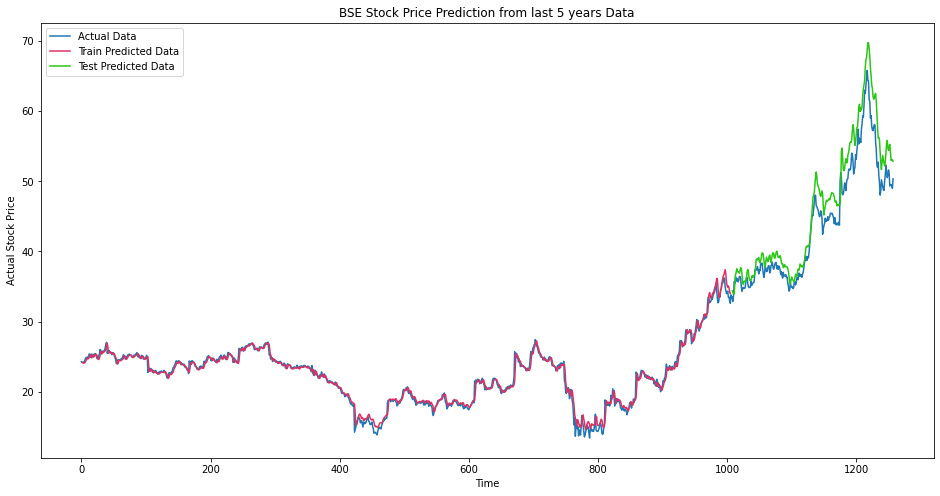

In [95]:
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df2), label = 'Actual Data')
plt.title('BSE Stock Price Prediction from last 5 years Data')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.plot(trainPredictPlot,color='#DE3163', label = 'Train Predicted Data')
plt.plot(testPredictPlot, color='#29c714', label = 'Test Predicted Data')
plt.legend(loc='best')
plt.show()

## Root Mean Square Error

In [96]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Training  = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Testing = ",testScore," RMSE")

Training  =  0.6225285820409058  RMSE
Testing =  2.907999748109104  RMSE


<hr>

# Textual Analysis

<h2><h2>

## Headline text (News Headline) Per City

In [97]:
city_headline = city_data.groupby(['City_Name']).agg({'News':'count'})
city_headline.rename(columns={'News':'Number_of_headline_text'},inplace=True)
city_headline = city_headline.sort_values(by='Number_of_headline_text',ascending=False)
top_15_headline_city = city_headline.head(15)
top_15_headline_city

,Number_of_headline_text
City_Name,
bengaluru,29
lucknow,21
patna,19
hyderabad,18
ahmedabad,17
pune,16
mumbai,15
kolkata,12
delhi,8


## Top 15 Cities which have high number of headline text

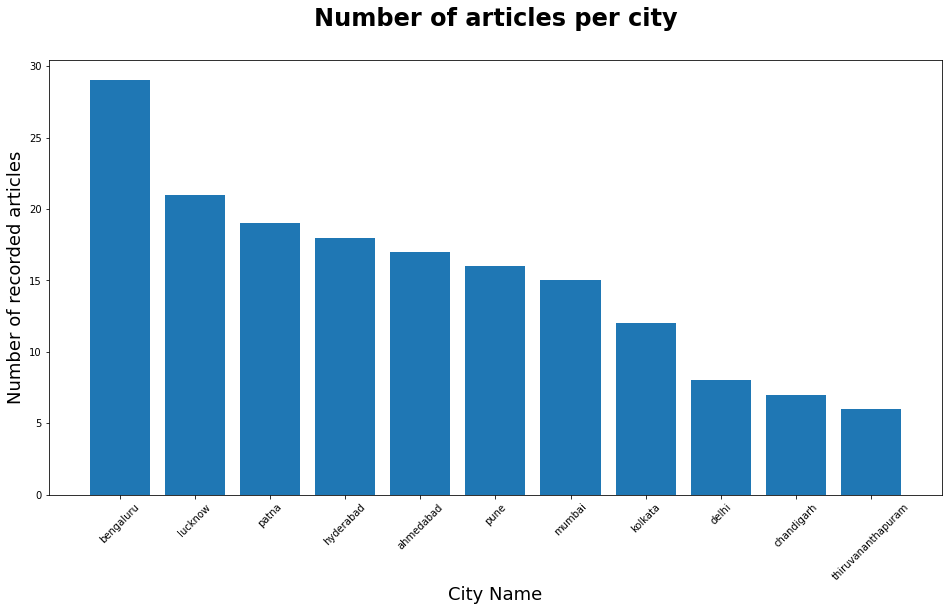

In [98]:
plt.figure(figsize=(16,8))
plt.bar(top_15_headline_city.index,height=top_15_headline_city['Number_of_headline_text'])
plt.xticks(rotation = 45)
plt.xlabel('City Name',fontsize=18)
plt.ylabel('Number of recorded articles',fontsize=18)
plt.title('Number of articles per city\n',fontsize=24, fontweight='bold')
plt.show()